# Plotting

This notebook is insanely messy because each plot is made within its own function, so the code is insanely redundant.
But the purpose of this notebook is purely exploratory, so ... no care given 🙃


In [2]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import circlify as circ
import squarify
import seaborn as sns

from pprint import pprint as pp 
from utils import print_pretty_df, wrap_label

# Quick ANSI color code shortcuts
r = "\033[31m"
y = "\033[33m"
g = "\033[32m"
b = "\033[34m"
e = "\033[0m"

pickleName = "all_datapoints_2024-12-26_14-57-47.pkl"
datapointsDfPath = Path("..") / ".." / "data" / "Review_ML-RS-FPGA" / "Dataframes" / pickleName
datapointsDf = pd.read_pickle(datapointsDfPath)

## Basic 1 dimensional plot

By "1D" it means I don't plot one of the main info against another. I keep it simple: bar plots with counts, or counts against times


### Implementation means


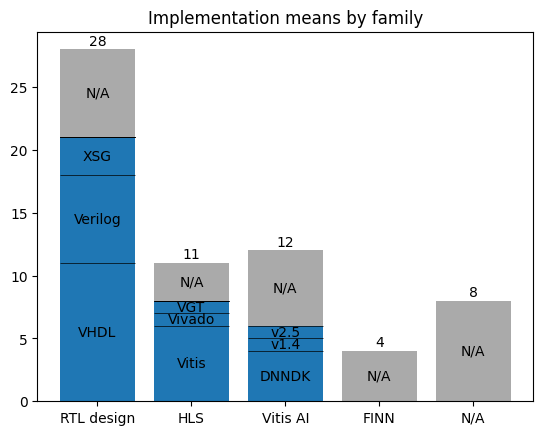

In [2]:
def barPlot_implMeans_perFamily_v1(implementationCounts) -> None:
    # --- Create Pivot Table ---
    # Transform the implementation counts into a DataFrame with categories and subcategories
    listImplCategories = []
    for fullTag, value in implementationCounts.items():
        mainCat = fullTag.split("(")[0].strip()
        subCat = fullTag.split("(")[1][:-1].strip() if "(" in fullTag else "N/A"
        listImplCategories.append([mainCat, subCat, value])

    implDf = pd.DataFrame(listImplCategories, columns=["Category", "SubCategory", "Count"])
    implDf = implDf.sort_values(by=["Count"])

    # Pivot the DataFrame to get the correct format for plotting
    subcatByCatCounts = implDf.pivot(index="Category", columns="SubCategory", values="Count").fillna(0)

    # --- Sort ---
    # Sort the categories: Create a 'Total' column, sort by it then drop it
    subcatByCatCounts["Total"] = subcatByCatCounts.sum(axis=1)
    subcatByCatCounts = subcatByCatCounts.sort_values(by="Total", ascending=False)
    subcatByCatCounts = subcatByCatCounts.drop(columns=["Total"])
    # Sort the catgeories by count and force the 'N/A' category on the right
    if "N/A" in subcatByCatCounts.index:
        new_index = [cat for cat in subcatByCatCounts.index if cat != "N/A"]
        subcatByCatCounts = subcatByCatCounts.reindex(new_index + ["N/A"])

    # Manually sort pivot table columns
    subcatByCatCounts = subcatByCatCounts[
        [
            "VHDL",
            "Verilog",
            "XSG",
            "Vitis",
            # "FINN", # FINN is now a category in itself
            "Vivado",
            "VGT",
            "DNNDK",
            "v1.4",
            "v2.5",
            "N/A",
        ]
    ]

    # --- Setup Plot ---
    categories = subcatByCatCounts.index
    subCategories = subcatByCatCounts.columns
    width = 0.8  # the width of the bars
    xAxisPositions = np.arange(len(categories))

    # --- Plot ---
    fig, ax = plt.subplots()
    bottom = np.zeros(len(categories))

    for i, subCat in enumerate(subCategories):
        counts = subcatByCatCounts[subCat].values
        if subCat == "N/A":
            color = "#aaaaaa"  # Gray for 'N/A'
        else:
            color = "#1f77b4"  # Default matplotlib blue
        p = ax.bar(
            xAxisPositions,
            counts,
            width,
            label=subCat,
            bottom=bottom,
            color=color,
        )
        bottom += counts
        ax.bar_label(
            p,
            labels=[f"{subCat}" if count > 0 else "" for count in counts],
            label_type="center",
        )

    # Set x-axis labels
    ax.set_xticks(xAxisPositions)
    ax.set_xticklabels(categories)

    # Add total count labels on top of each bar
    catTotalCount = subcatByCatCounts.sum(axis=1)
    for i, total in enumerate(catTotalCount):
        ax.text(xAxisPositions[i], total + 0.1, f"{int(total)}", ha="center", va="bottom")

    # Add horizontal lines between sub-categories
    catCumulativeCount = subcatByCatCounts.cumsum(axis=1)
    for idx, category in enumerate(categories):
        lineStart = xAxisPositions[idx] - width / 2
        lineStop = xAxisPositions[idx] + width / 2
        yAxisPosition = catCumulativeCount.loc[category].values
        for y in yAxisPosition[:-1]:  # Exclude the last total yAxisPosition
            if y > 0:
                ax.hlines(y, lineStart, lineStop, colors='black', linewidth=0.5)

    ax.set_title("Implementation means by family")

    plt.show()

barPlot_implMeans_perFamily_v1(datapointsDf["Implementation"].value_counts())

C:\Users\leon_ce\AppData\Local\Temp\ipykernel_31708\3886601662.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['Implementation', 'Publication year']).size().reset_index(name='Count')


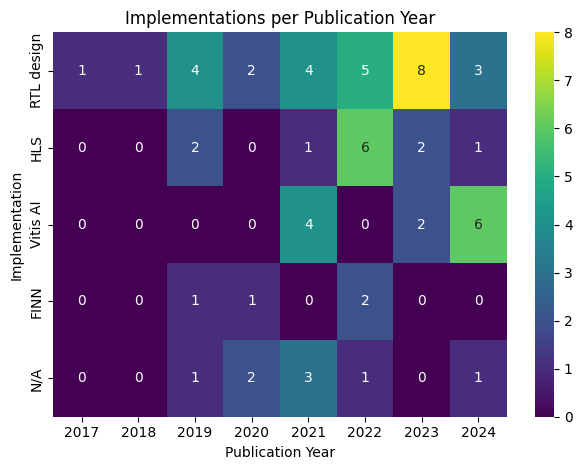

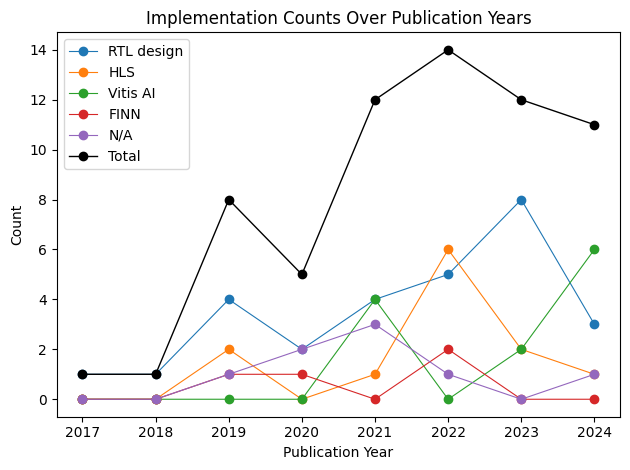

In [3]:
def heatmap_implMeans_perYear_v2(DataFrame, groupedByType=False, linePlot=False):
    """
    Plot a heatmap showing the counts of Implementations per Publication Year.
    When 'groupedByType' is True, groups implementations by their base type.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Implementation' and 'Publication year' columns.
        groupedByType (bool): If True, group implementations by their base type.
    """
    # Copy the DataFrame to avoid modifying the original data
    df = DataFrame.copy()
    df['Implementation'] = df['Implementation'].apply(lambda x: x if isinstance(x, list) else [x])
    df = df.explode('Implementation')
    
    if groupedByType:
        df['Implementation'] = df['Implementation'].apply(lambda x: x.split('(')[0].strip())
        df['Implementation'] = pd.Categorical(df['Implementation'], ['RTL design', 'HLS', 'Vitis AI', 'FINN', 'N/A'])
    
    # Prepare the data
    counts = df.groupby(['Implementation', 'Publication year']).size().reset_index(name='Count')
    pivot_df = counts.pivot(index='Implementation', columns='Publication year', values='Count').fillna(0)
    
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)
    
    # Plotting
    # plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt='g', cmap='viridis')
    plt.title('Implementations per Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('Implementation')
    plt.tight_layout()
    plt.show()

    if linePlot:
        # Add a 'Total' row
        pivot_df.loc['Total'] = pivot_df.sum()

        fig, ax = plt.subplots()
        # Plot all implementations with a thinner line
        pivot_df.drop('Total').T.plot(ax=ax, marker='o', linewidth=0.8)
        # Plot the 'Total' line thicker and in black
        pivot_df.loc['Total'].T.plot(ax=ax, marker='o', linewidth=1, color='black', label='Total')

        plt.title('Implementation Counts Over Publication Years')
        plt.xlabel('Publication Year')
        plt.ylabel('Count')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

# Example usage
# Assuming 'allModelsDF' is your DataFrame
# To plot without grouping:
# heatmap_implMeans_perYear_v2(allModelsDF[['Implementation', 'Publication year']], groupedByType=False)

# To plot with grouping:
heatmap_implMeans_perYear_v2(datapointsDf[['Implementation', 'Publication year']], groupedByType=True, linePlot=True)

### FPGA Boards


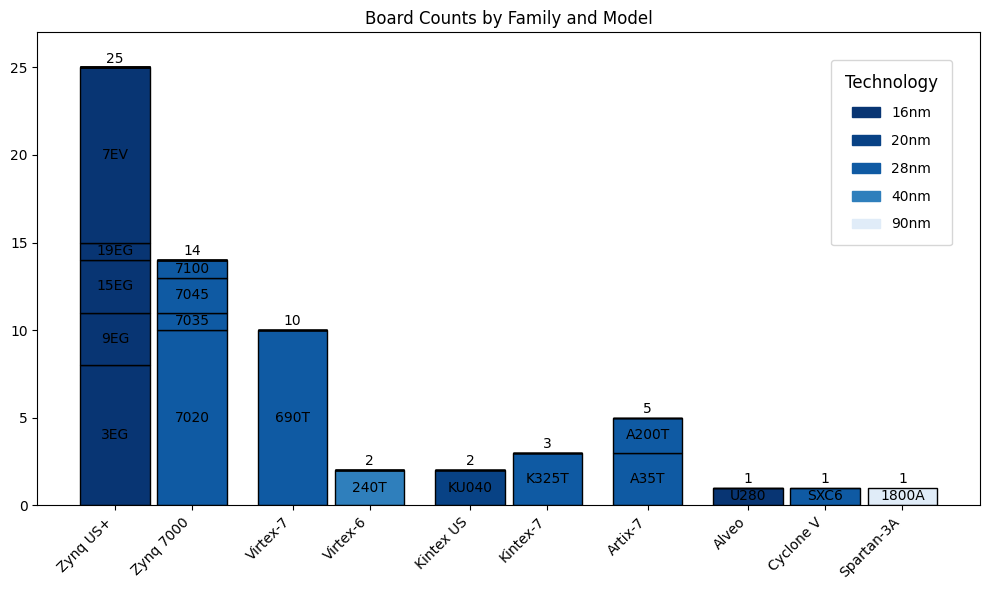

In [4]:
def barPlot_FPGA_perFamily_v2(modelCountsPerFPGA) -> None:
    """
    Modify the colors of the sub-bars to match the technology feature size in nm.
    Uses a color scale proportional to the feature size.
    """
    def determine_board_family_group(index: str) -> str:
        return index.split("(")[0].strip()

    def determine_board_model(index: str) -> str:
        return index.split("(")[1].split(")")[0].strip()
    
    def rename_board_models() -> dict[str, str]:
        return {
            "ZU3EG": "3EG", "ZU9EG": "9EG", "ZU15EG": "15EG", "ZU19EG": "19EG", "ZU7EV": "7EV",
            "Z7020": "7020", "Z7035": "7035", "Z7045": "7045", "Z7100": "7100",
            "VX690T": "690T", "VLX240T": "240T",
            "XCKU040": "KU040", "XC7K325T": "K325T",
            "XC7A35T": "A35T",
            "XC7A200T": "A200T", "5CSXC6": "SXC6", "XC3SD1800A": "1800A",
            "U280": "U280",
        }

    def get_ordered_families() -> list[str]:
        return [
            "Zynq US+", "Zynq 7000",
            "Virtex-7", "Virtex-6",
            "Kintex US", "Kintex-7",
            "Artix-7",
            "Alveo", "Cyclone V", "Spartan-3A",
        ]
    
    def get_ordered_models() -> list[str]:
        return [
            "3EG", "9EG", "15EG", "19EG", "7EV",
            "7020", "7035", "7045", "7100",
            "240T", "690T",
            "KU040", "K325T",
            "A35T", "A200T",
            "U280", "SXC6", "1800A",
        ]

    # --- Prepare Data ---
    allBoardsList = []
    for index, value in modelCountsPerFPGA.items():
        family = determine_board_family_group(index)
        model = determine_board_model(index)
        allBoardsList.append([family, model, value])
    allBoardsDF = pd.DataFrame(allBoardsList, columns=["Family", "Model", "Count"])
    allBoardsDF["Model"] = allBoardsDF["Model"].replace(rename_board_models())

    # Map feature size to each family
    fpgaTechnology = {
        "Spartan-3A": "90nm",
        "Virtex-6": "40nm",
        "Virtex-7": "28nm",
        "Kintex-7": "28nm",
        "Artix-7": "28nm",
        "Cyclone V": "28nm",
        "Zynq 7000": "28nm",
        "Kintex US": "20nm",
        "Alveo": "16nm",
        "Zynq US+": "16nm",
    }
    allBoardsDF["FeatureSize"] = allBoardsDF["Family"].map(fpgaTechnology)
    # Convert feature sizes to numeric values
    feature_size_map = {"90nm": 90, "40nm": 40, "28nm": 28, "20nm": 20, "16nm": 16}
    allBoardsDF["FeatureSizeValue"] = allBoardsDF["FeatureSize"].map(feature_size_map)

    # Aggregate counts for each combination of Family and Model
    allBoardsDF = allBoardsDF.groupby(["Family", "Model", "FeatureSizeValue"]).sum().reset_index()

    # --- Manual Sort ---
    sortedFamilies = get_ordered_families()
    allBoardsDF["Family"] = pd.Categorical(allBoardsDF["Family"], categories=sortedFamilies, ordered=True)
    allBoardsDF = allBoardsDF.sort_values(by=["Family", "Model"])

    # Pivot the DataFrame to get the correct format for plotting
    familyVsModelTable = allBoardsDF.pivot(index="Family", columns="Model", values="Count").fillna(0)
    familyVsModelTable = familyVsModelTable[get_ordered_models()]

    # Map feature size to colors using a colormap
    min_size = allBoardsDF["FeatureSizeValue"].min() - 2
    max_size = allBoardsDF["FeatureSizeValue"].max() + 10
    norm = matplotlib.colors.Normalize(vmin=min_size, vmax=max_size)
    cmap = matplotlib.colormaps['Blues_r']  # Reverse Blues colormap for smaller nm values to be darker

    # Assign colors to families based on feature size
    familyColors = {}
    for family in sortedFamilies:
        feature_size_value = allBoardsDF[allBoardsDF["Family"] == family]["FeatureSizeValue"].iloc[0]
        color = cmap(norm(feature_size_value))
        familyColors[family] = color

    # Define positions with gaps between groups
    barXPositions = []
    gapBetweenGroup = 0.3
    currentPos = 0
    for category in sortedFamilies:
        if category in ["Virtex-7", "Kintex US", "Artix-7", "Alveo"]:
            currentPos += gapBetweenGroup
        barXPositions.append(currentPos)
        currentPos += 1

    # Plotting
    families = familyVsModelTable.index
    models = familyVsModelTable.columns
    width = 0.9  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    barYPosition = np.zeros(len(families))

    for i, model in enumerate(models):
        counts = familyVsModelTable[model].values
        # Colors for each family based on feature size
        colors = [familyColors[family] for family in families]
        p = ax.bar(barXPositions, counts, width, label=model, bottom=barYPosition, color=colors, edgecolor='black')
        barYPosition += counts
        ax.bar_label(
            p,
            labels=[
                f"{model}" if count > 0 else ""
                for count in counts
            ],
            label_type="center",
            fontsize=10,
        )

    # Add total count labels on top of each bar
    totalNbModelPerFamily = familyVsModelTable.sum(axis=1)
    for pos, total in zip(barXPositions, totalNbModelPerFamily):
        ax.text(pos, total + 0.1, f"{int(total)}", ha="center", va="bottom")

    # Add horizontal lines between the models of each family
    for i, family in enumerate(families):
        count = 0
        for j, model in enumerate(models):
            count += familyVsModelTable[model][family]
            ax.hlines(
                y=count,
                xmin=barXPositions[i] - width / 2,
                xmax=barXPositions[i] + width / 2 - 0.05,
                color="black",
                linewidth=0.5,
            )

    # Create a custom legend for feature sizes
    handles = []
    for size in sorted(feature_size_map.values()):
        color = cmap(norm(size))
        label = f"{size}nm"
        patch = mpatches.Patch(color=color, label=label)
        handles.append(patch)
    # ax.legend(handles=handles, title='Technology', loc='upper right')
    ax.legend(
        handles=handles,
        title='Technology',
        loc='upper right',
        title_fontsize=12,     # Increase the title font size
        fontsize=10,           # Increase the label font size
        borderpad=1,           # Increase the padding between the border and the content
        labelspacing=1,        # Increase the vertical space between labels
        handlelength=2,        # Increase the length of the legend handles
        handletextpad=0.8,     # Increase space between handle and text
        borderaxespad=2.0      # Increase the space between the legend and the axes
    )

    ax.set_title("Board Counts by Family and Model")

    # Rotate x-axis labels
    ax.set_xticks(barXPositions)
    ax.set_xticklabels(sortedFamilies, rotation=45, ha="right")
    ax.set_ylim(top=ax.get_ylim()[1] + 2)  # Add some space at the top

    plt.tight_layout()
    plt.show()

barPlot_FPGA_perFamily_v2(datapointsDf["Board"].value_counts())

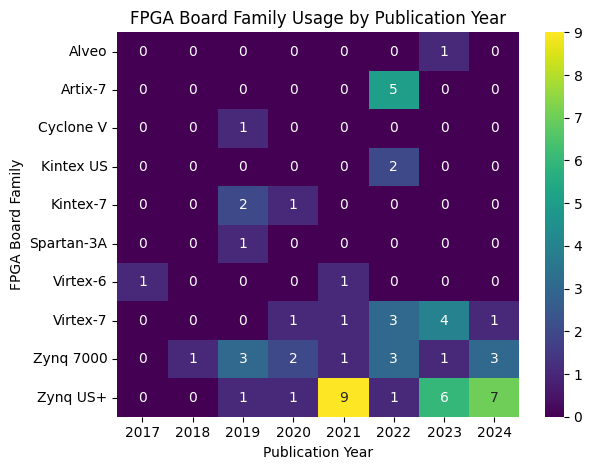

In [5]:
def heatmap_FPGA_perFamily_v1(DataFrame):
    """
    Plot a heatmap showing the number of times each FPGA board family was used per publication year.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Board' and 'Publication year' columns.
    """

    # Copy the DataFrame to avoid modifying the original data
    DF = DataFrame.copy()

    # Extract the family from the 'Board' column
    def extract_family(board_name):
        # Assuming the format is "Family (Model)"
        if '(' in board_name:
            return board_name.split('(')[0].strip()
        else:
            return board_name.strip()

    DF['Family'] = DF['Board'].apply(extract_family)

    # Prepare the data
    # Group by 'Publication year' and 'Family', count occurrences
    Counts = DF.groupby(['Publication year', 'Family']).size().reset_index(name='Count')

    # Pivot the data to create a matrix suitable for heatmap
    PivotDF = Counts.pivot(index='Family', columns='Publication year', values='Count').fillna(0)

    # Sort the families and years for better visualization
    PivotDF = PivotDF.sort_index()
    PivotDF = PivotDF.reindex(sorted(PivotDF.columns), axis=1)  # Sort columns

    # Plotting
    # plt.figure(figsize=(12, 8))
    sns.heatmap(PivotDF, annot=True, fmt='g', cmap='viridis')

    plt.title('FPGA Board Family Usage by Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('FPGA Board Family')

    plt.tight_layout()
    plt.show()

# Example usage
heatmap_FPGA_perFamily_v1(datapointsDf[['Board', 'Publication year']])

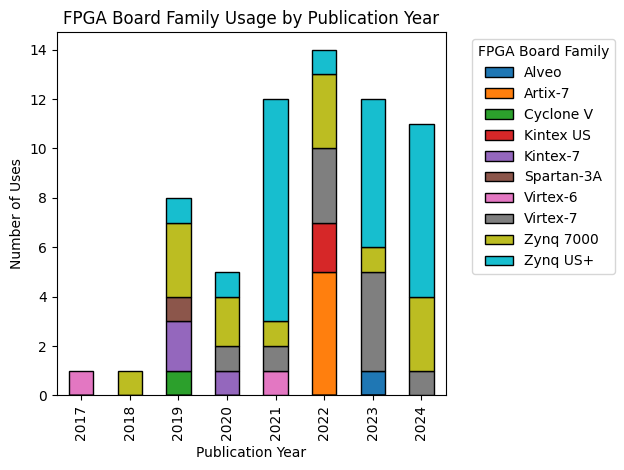

In [6]:
def barPlot_FPGA_perYear_v1(DataFrame):
    """
    Plot a stacked bar chart showing the number of times each FPGA board family was used per publication year.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Board' and 'Publication year' columns.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Copy the DataFrame to avoid modifying the original data
    df = DataFrame.copy()

    # Extract the family from the 'Board' column
    def extract_family(board_name):
        # Assuming the format is "Family (Model)"
        if '(' in board_name:
            return board_name.split('(')[0].strip()
        else:
            return board_name.strip()

    df['Family'] = df['Board'].apply(extract_family)

    # Group by 'Publication year' and 'Family', count occurrences
    counts = df.groupby(['Publication year', 'Family']).size().reset_index(name='Count')

    # Pivot the data to create a DataFrame suitable for plotting
    pivot_df = counts.pivot(index='Publication year', columns='Family', values='Count').fillna(0)

    # Sort the years and families
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df.sort_index(axis=1)

    # Plotting
    ax = pivot_df.plot(kind='bar', stacked=True, edgecolor='black')

    plt.title('FPGA Board Family Usage by Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('Number of Uses')
    plt.legend(title='FPGA Board Family', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Example usage
barPlot_FPGA_perYear_v1(datapointsDf[['Board', 'Publication year']])

### ML models


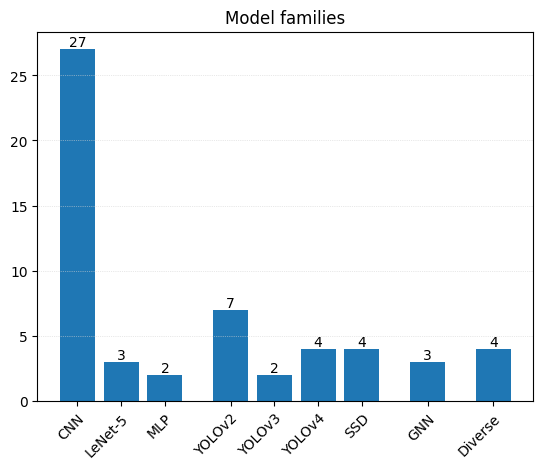

In [7]:
def barPlot_equivalentModel_v1(modelCounts):
    # --- Prepare Data ---
    # Combine categories with only one count into 'Diverse'
    modelCounts = modelCounts.copy()
    modelCounts = modelCounts[modelCounts > 1]
    modelCounts["Diverse"] = modelCounts[modelCounts == 1].sum()

    # --- Sort ---
    # Define the order of the bars by ML task family
    taskFamilies: dict[str, list[str]] = {
        "Classification": [
            "CNN",
            "LeNet-5",
            "MLP",
            "VGG16",
            "VGG11",
            "AlexNet",
            "ResNet-34",
            "MobileNetv1",
        ],
        "Object Detection": [
            "YOLOv2",
            "YOLOv3",
            "YOLOv4",
            "YOLOv4-tiny",
            "SSD300-HW",
            "SSD",
        ],
        "Other tasks": ["GNN", "SVM", "U-Net", "IORN4"],
        "Diverse": ["Diverse"],
    }
    # Unroll task families into order
    order: list[str] = [model for task in taskFamilies.values() for model in task]
    # Reorder the modelCounts according to the specified order
    modelCounts = modelCounts.reindex(order).dropna()

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette
    colors: list[str] = [
        "#2066a8",  # Blues for Classification
        "#4B93BA",
        "#8cc5e3",
        "#AFD8ED",
        "#A71313",  # Reds for Object Detection
        "#af2c2c",
        "#c46666",
        "#E18A8A",
        "#F7ABAB",
        "#1f6f6f",  # Teals for diverse boards
        "#54a1a1",
        "#aaaaaa",  # Gray for Diverse
        # "#9fc8c8", # Last teal variation
    ]

    # Define positions with gaps between task families
    positions = []
    gap = 0.5  # Define the gap size
    currentPos = 0
    for task, family in taskFamilies.items():
        for model in family:
            if model in modelCounts.index:
                positions.append(currentPos)
                currentPos += 1
        currentPos += gap

    # --- Plot ---
    fig, ax = plt.subplots()
    bars = ax.bar(positions, modelCounts.values)

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    # Add horizontal dotted lines for the ticks of the vertical axis
    ax.yaxis.grid(True, linestyle=":", linewidth=0.5, color="lightgray")

    ax.set_title("Model families")

    # Rotate x-axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels(
        modelCounts.index, rotation=45, ha="right", rotation_mode="anchor"
    )

    plt.show()

barPlot_equivalentModel_v1(datapointsDf["Equivalent model"].value_counts())

### Datasets and Tasks


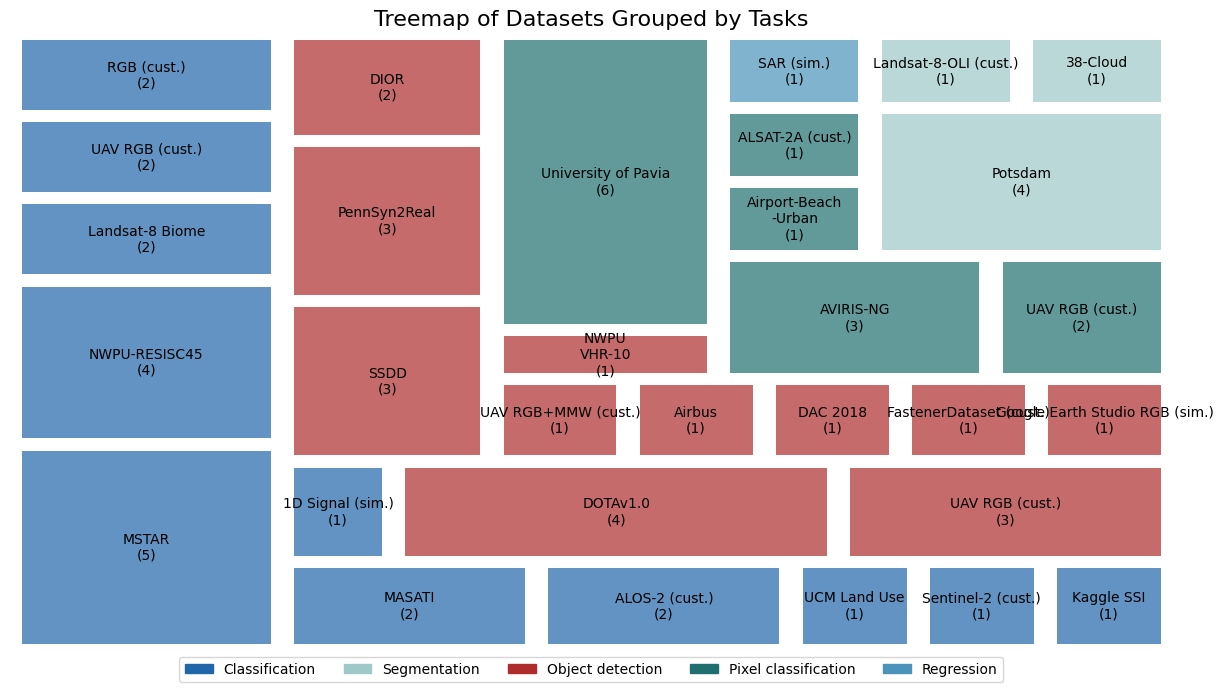

In [8]:
def prepare_dataset_data(df):
    # Rename some of the datasets (make them shorter, etc.)
    datasetMapping: dict[str, str] = {
        "University of Pavia {Pixel classification}": "University of Pavia {Pixel classification}",
        "Multi-drone (custom) {Object Detection}": "Multi-drone (cust.) {Object Detection}",
        "Custom (UAV) {Pixel classification}": "UAV RGB (cust.) {Pixel classification}",
        "Custom (ALOS-2) {Classification}": "ALOS-2 (cust.) {Classification}",
        "L8 Biome {Classification}": "Landsat-8 Biome {Classification}",
        "Custom (UAV) {Object Detection}": "UAV RGB (cust.) {Object Detection}",
        "Custom (ALSAT-2A) {Pixel classification}": "ALSAT-2A (cust.) {Pixel classification}",
        "Custom (Landsat-8-OLI) {Segmentation}": "Landsat-8 OLI (cust.) {Segmentation}",
        "Simulated (SAR) {Regression}": "SAR (sim) {Regression}",
        "Custom (UAV) {Classification}": "UAV RGB\n(cust.) {Classification}",
        "Simulated (RGB) {Object Detection}": "Google Earth\nRGB (sim) {Object Detection}",
        "Simulated (1-D Signal) {Classification}": "1D signal (sim) {Classification}",
        "Custom (Sentinel-2) {Classification}": "Sentinel-2\n(cust.) {Classification}",
        "UC-Merced Land Use {Classification}": "UCM Land Use {Classification}",
        "Airport-Beach-Urban {Pixel classification}": "Airport-Beach\n-Urban {Pixel classification}",
        "FastenerDataset {Object Detection}": "Fastener\nDataset {Object Detection}",
        "NWPU VHR-10 {Object Detection}": "NWPU\nVHR-10 {Object Detection}",
        "Google Earth Studio RGB (sim) {Object Detection}": "Google Earth\nRGB (sim) {Object Detection}",
    }
    df.loc[:, "Dataset"] = df["Dataset"].replace(datasetMapping)

    # Generate dataset counts and tasks
    datasetCounts = df[
        ["Dataset", "Task"]
    ].value_counts()  # Count occurrences of each dataset
    # print(datasetCounts.index, '\n', len(datasetCounts))
    tasks = df["Task"].unique()  # Get the unique tasks

    # Prepare the dataset labels (without task names)
    datasetLabels = [
        label.split(" {")[0]
        for label in datasetCounts.index.get_level_values("Dataset")
    ]  # Keep only the dataset name
    counts = datasetCounts.values  # Extract the counts

    # Create labels that combine dataset name with the corresponding count
    labels = [f"{dataset}\n({count})" for dataset, count in zip(datasetLabels, counts)]

    # Create a color map to differentiate the tasks
    taskToColorDict = {
        "Classification": "#2066a8",
        "Pixel classification": "#1f6f6f",
        "Segmentation": "#9fc8c8",
        "Object detection": "#af2c2c",
        "Regression": "#4B93BA",
    }
    # # Colormap as it appears
    # taskToColorDict = {
    #     "Classification": "#6293c2",
    #     "Pixel classification": "#629a9a",
    #     "Segmentation": "#bbd8d8",
    #     "Object detection": "#c66b6b",
    #     "Regression": "#80b3ce",
    # }


    # Assign colors based on the task of each dataset
    colors = [
        taskToColorDict[task] for task in datasetCounts.index.get_level_values("Task")
    ]
    return datasetCounts, counts, tasks, labels, taskToColorDict, colors


def treemap_datasets_perTask_v1(df):
    """
    Function to plot a treemap of datasets and their counts using the provided tasks and dataset_counts.
    The color is mapped to the tasks.
    :param df: A DataFrame containing the columns 'Task' and 'Dataset'
    """

    datasetCounts, counts, tasks, labels, taskToColorDict, colors = prepare_dataset_data(df)

    # Sort the datasets by task to group by color
    sortedIndices = sorted(
        range(len(colors)),
        key=lambda i: datasetCounts.index.get_level_values("Task")[i],
    )
    counts = [counts[i] for i in sortedIndices]
    labels = [labels[i] for i in sortedIndices]
    colors = [colors[i] for i in sortedIndices]

    # Plotting the treemap
    plt.figure(figsize=(15, 8))

    # squarify.plot requires the 'sizes' (dataset counts) and optional 'label' and 'color'
    squarify.plot(
        sizes=counts,
        label=labels,
        color=colors,
        alpha=0.7,
        text_kwargs={"fontsize": 10},
        pad=True,
    )

    # Title and layout adjustments
    plt.title("Treemap of Datasets Grouped by Tasks", fontsize=16)
    plt.axis("off")  # Turn off the axes for better visibility

    # Add legend for each color
    handles = [plt.Rectangle((0, 0), 1, 1, color=taskToColorDict[task]) for task in tasks]
    plt.legend(handles, tasks, loc="upper center", bbox_to_anchor=(0.5, 0), ncol=5)

    # Show the plot
    plt.show()

treemap_datasets_perTask_v1(datapointsDf[["Task", "Dataset"]])

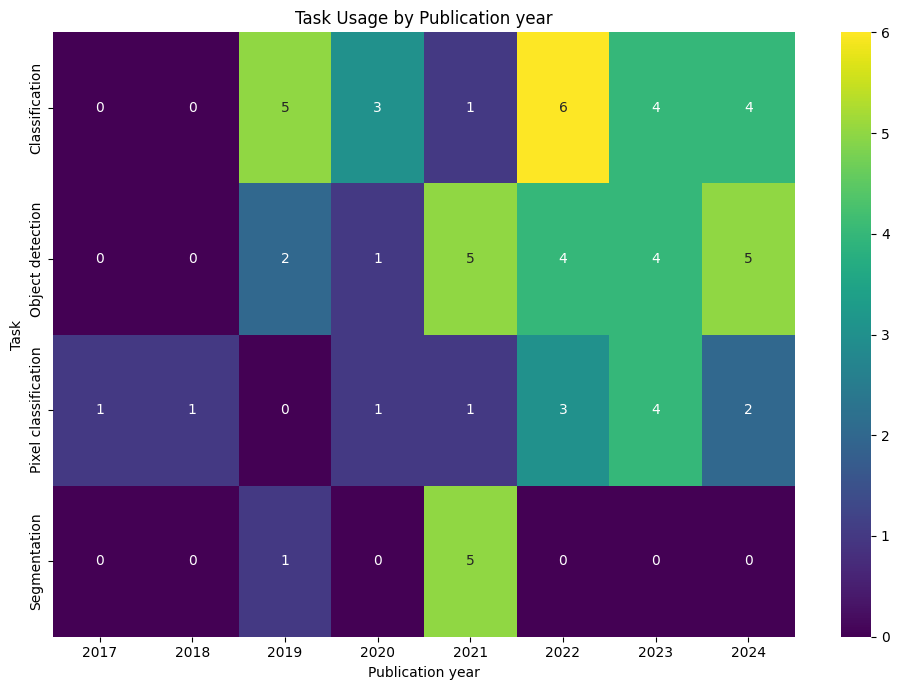

In [9]:
def plot_task_usage_heatmap(DataFrame):
    """
    Plot a heatmap showing the number of times each Task was used per Publication year.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Task' and 'Publication year' columns.
    """
    # Prepare the data
    Counts = DataFrame.groupby(['Publication year', 'Task']).size().reset_index(name='Count')
    PivotDF = Counts.pivot(index='Task', columns='Publication year', values='Count').fillna(0)
    PivotDF = PivotDF.sort_index()
    PivotDF = PivotDF.reindex(sorted(PivotDF.columns), axis=1)

    # Remove Regression
    PivotDF = PivotDF.drop('Regression', errors='ignore')

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(PivotDF, annot=True, fmt='g', cmap='viridis')
    plt.title('Task Usage by Publication year')
    # plt.xlabel('Publication year')
    # plt.ylabel('Task')
    plt.tight_layout()
    plt.show()

# Example usage
plot_task_usage_heatmap(datapointsDf[['Task', 'Publication year']])

## Higher dimensions plot


### Focus on RS applications


##### First some last minute renaming:


In [ ]:
datapointsDf.replace({
    'Redshift estimation [regression]': 'Redshift estimation',
    'Railway track fastener defect detection': 'Railway defect detection',
    'Diverse': 'Miscellaneous targets',
    'General': 'Unsupervised'
}, inplace=True)

application_to_group = {
    # Environmental Monitoring
    "Cloud detection": "Environmental Monitoring",
    "Air Quality Monitoring": "Environmental Monitoring",
    "Deforestation detection": "Environmental Monitoring",
    "Oil spills feature extraction": "Environmental Monitoring",
    # Landscape Analysis
    "Terrain identification": "Landscape Analysis",
    "Anomaly detection": "Landscape Analysis",
    "Urban areas": "Landscape Analysis",
    "Unsupervised": "Landscape Analysis",

    # Target Detection
    "Ship detection": "Target Detection",
    "Ship identification": "Target Detection",
    "Aircraft detection": "Target Detection",
    "Flying-object detection": "Target Detection",
    "Military targets identification": "Target Detection",
    "Miscellaneous targets": "Target Detection",
    
    # Navigation
    "UAV obstacles detection": "Navigation",
    "Safe UAV landing site detection": "Navigation",
    # Miscellaneous (Diverse)
    "Railway defect detection": "Diverse",
    "Redshift estimation": "Diverse",
}

datapointsDf['Group'] = datapointsDf['Application'].map(application_to_group)
print_pretty_df(datapointsDf[['Group', 'Application', 'Modality']].sort_values(by='Group'))
# datapointsDf[['BBT Citation Key', 'Task', 'Modality', 'Application', 'Group']].to_csv(datapointsDfPath / ".." / "applications.csv", index=False)

+----+--------------------------+---------------------------------+----------------+
|    |          Group           |           Application           |    Modality    |
+----+--------------------------+---------------------------------+----------------+
| 52 |         Diverse          |    Railway defect detection     |      RGB       |
| 34 |         Diverse          |       Redshift estimation       |       1D       |
| 1  | Environmental Monitoring |         Cloud detection         |      RGB       |
| 53 | Environmental Monitoring |         Cloud detection         |      HSI       |
| 6  | Environmental Monitoring |  Oil spills feature extraction  |      SAR       |
| 17 | Environmental Monitoring |     Deforestation detection     |      RGB       |
| 16 | Environmental Monitoring |         Cloud detection         |      RGB       |
| 15 | Environmental Monitoring |         Cloud detection         |      RGB       |
| 36 | Environmental Monitoring |     Air Quality Monitoring     

In [33]:
def get_modality_hatch_pattern(app, patterns):
    """
    Returns a hatch pattern based on the application modality. We look at the set of
    modalities for a given 'app' in the DataFrame 'datapointsDf', then:
      1. If a single modality is found in >= 70% of the rows, return its pattern.
      2. Otherwise, if at least two modalities are present:
         If the top two modalities occur with roughly close frequency, combine their patterns.
         Otherwise, return only the top modality's pattern.
      3. If no matches or empty, return an empty pattern.

    'patterns' is a dict like:
        {
         'RGB': '//',
         'HSI': '||',
         'SAR': '++',
         '1D': '*',
        }
    """
    appModalities = datapointsDf[datapointsDf['Application'] == app]['Modality']
    appModalities = appModalities.replace({'RGB + infrared': 'RGB', 'RGB + MMW': 'RGB'}) # Simplified some combined labels

    if len(appModalities) == 0:
        return ""

    # Get frequencies of each modality
    counts = appModalities.value_counts()
    total = counts.sum()
    if len(counts) == 1: return patterns.get(counts.index[0], "")

    # Sort by frequency (already sorted from value_counts by default), check if top modality >= 70%
    topModality = counts.index[0]
    topCount = counts.iloc[0]
    if topCount / total >= 0.7:
        # Return that top modality's pattern
        return patterns.get(topModality, "")

    # Otherwise, check if second-most frequent is "roughly" close
    if len(counts) >= 2:
        secondModality = counts.index[1]
        secondCount = counts.iloc[1]

        # Let's say "roughly close" means the ratio of secondCount to topCount is at least 0.7
        if secondCount / topCount >= 0.7:
            # Combine top two patterns only
            patternA = patterns.get(topModality, "")
            patternB = patterns.get(secondModality, "")
            return patternA + patternB
        else:
            # Not close enough => return the top modality pattern
            return patterns.get(topModality, "")

##### The actual plotting

The computations for the circles sizes and positions is made with `circlify`, see their [GitHub](https://github.com/elmotec/circlify/tree/main) for examples.
The plotting is based on `circlify.bubbles` function (using `matplotlib`), but I made it a wee bit more elaborated (and fit to my needs obviously).


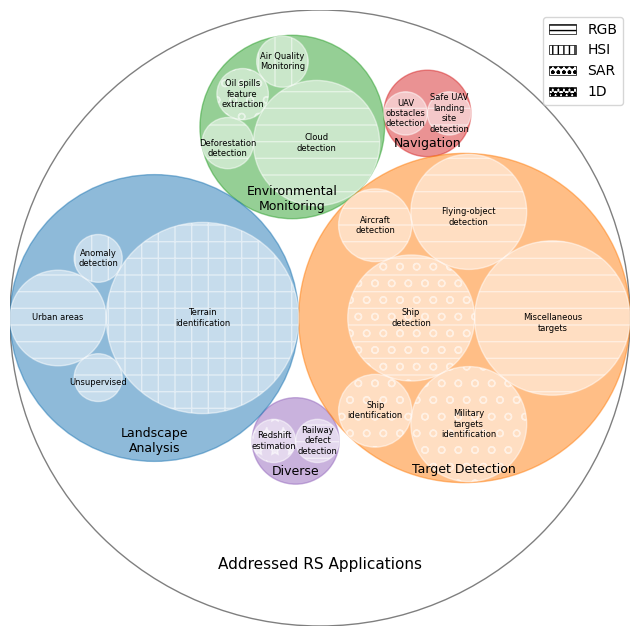

In [40]:
def plot_bubbles_custom(circles, labels, fillColors, hatchPatterns, fontsize=8, lim=None, withBase=True):
    """
    Displays circles with matplotlib. 
    We draw two sets of circles:
      1) The group circles (level == 1) with labels at the bottom, bigger font.
      2) The child circles (level == 2) with labels centered, default font.
    - 'circles': list of circlify.Circle objects (x, y, r, level, ex, parent)
    - 'labels': parallel list of strings
    - 'fillColors': parallel list of fill colors
    - 'fontsize': default font size for child labels
    - 'lim': axis limit; if None, autoset
    - 'withBase': also plots the "root" circle, containing all the groups
    """
    _, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')  # Remove all axes/borders

    # Split circles into group-level vs child-level
    baseCircle = (circles[0], labels[0], fillColors[0])
    groupCircles = []
    childCircles = []
    for circle, label, color in zip(circles[1:], labels[1:], fillColors[1:]):
        if circle.level == 1:
            groupCircles.append((circle, label, color))
        elif circle.level == 2:
            childCircles.append((circle, label, color))
        else:
            raise ValueError(f"Circles with Levels higher than 2 not supported: {circle}, level {circle.level}")

    # Draw the base circle (enclosure)
    if withBase:
        ax.add_patch(plt.Circle((baseCircle[0].x, baseCircle[0].y), baseCircle[0].r, fill=False, alpha=0.5, linewidth=1))
        ax.text(baseCircle[0].x, baseCircle[0].y - baseCircle[0].r + 0.2, "Addressed RS Applications", ha='center', va='center', fontsize=fontsize + 5)

    # Draw group-level circles (bigger text, label at bottom)
    for circle, label, color in groupCircles:
        x, y, r = circle.x, circle.y, circle.r
        ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=1, fill=True, color=color))
        ax.text(x, y - r + 0.02, wrap_label(label, 18), ha='center', va='bottom', fontsize=fontsize + 3)

    # Draw child-level circles (default text, label centered)
    for circle, label, color in childCircles:
        x, y, r = circle.x, circle.y, circle.r
        ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=1, fill=True, color=color, hatch=get_modality_hatch_pattern(label, hatchPatterns)))
        ax.text(x, y, wrap_label(label, 12), ha='center', va='center', fontsize=fontsize)

    # Auto-limit the axes if lim is not provided
    if lim is None:
        lim = max(
            max(abs(c_obj.x) + c_obj.r, abs(c_obj.y) + c_obj.r)
            for c_obj in circles
        )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # Build legend for modalities (hatches)
    legendPatches = []
    for modality, pattern in hatchPatterns.items():
        legendPatches.append(mpatches.Patch(
            facecolor='white', edgecolor='black', hatch=pattern*3, label=modality, linewidth=0.5
        ))
    ax.legend(handles=legendPatches, loc='upper right', fontsize=10)

    plt.show()

def plot_hierarchical_circle_packing_from_counts(datapointsDf):
    """
    Given a Series indexed by ['Group', 'Application'] with count values,
    build hierarchical data for circlify:
    [
      {
        'id': <group_name>, 
        'datum': <sum_of_counts_for_this_group>,
        'children': [
          {'id': <application_name>, 'datum': <count>}, 
          ...
        ]
      },
      ...
    ]
    Then plot using circlify.
    """
    # Convert series to DataFrame if needed,columns: Group, Application, Count
    df = datapointsDf[['Group', 'Application']].value_counts().reset_index(name='Count')
    df.columns = ['Group', 'Application', 'Count']
    df.sort_values(by=['Group'], inplace=True)

    data = []
    for group_val, group_subset in df.groupby('Group'):
        total_count = group_subset['Count'].sum()
        children = []
        for _, row in group_subset.iterrows():
            children.append({
                'id': row['Application'],
                'datum': row['Count']
            })
        data.append({
            'id': group_val,
            'datum': total_count,
            'children': children
        })
    # pp(data)
    
    circles = circ.circlify(data, show_enclosure=True)
    labels = []
    for c in circles:
        label = c.ex.get("id", "") if c.ex else ""
        labels.append(label)
    # pp(circles)

    # Make a list of default colors for the groups (5 first circles)
    # Blue (Matisse) 1f77b4
    # Orange (Flamenco) ff7f0e
    # Green (Forest Green) 2ca02c
    # Red (Punch) d62728
    # Purple (Wisteria) 9467bd
    colors = ['white', # Base circle
                         '#9467bd', # Diverse
                         '#d62728', # Target Detection
                         '#2ca02c', # Environmental Monitoring
                         '#1f77b4', # Landscape Analysis
                         '#ff7f0e', # Navigation
    ]
    for _ in range(len(circles) - len(colors)): colors.append('white') # All children circles go white

    modalityPatterns = {
        'RGB': '-',
        'HSI': '|',
        'SAR': 'o',
        '1D': '*',
    }

    plot_bubbles_custom(circles, labels, colors, modalityPatterns, fontsize=6, withBase=True)

plot_hierarchical_circle_packing_from_counts(datapointsDf)

C:\Users\leon_ce\AppData\Local\Temp\ipykernel_37064\697058365.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom_stack[i] + val / 2,


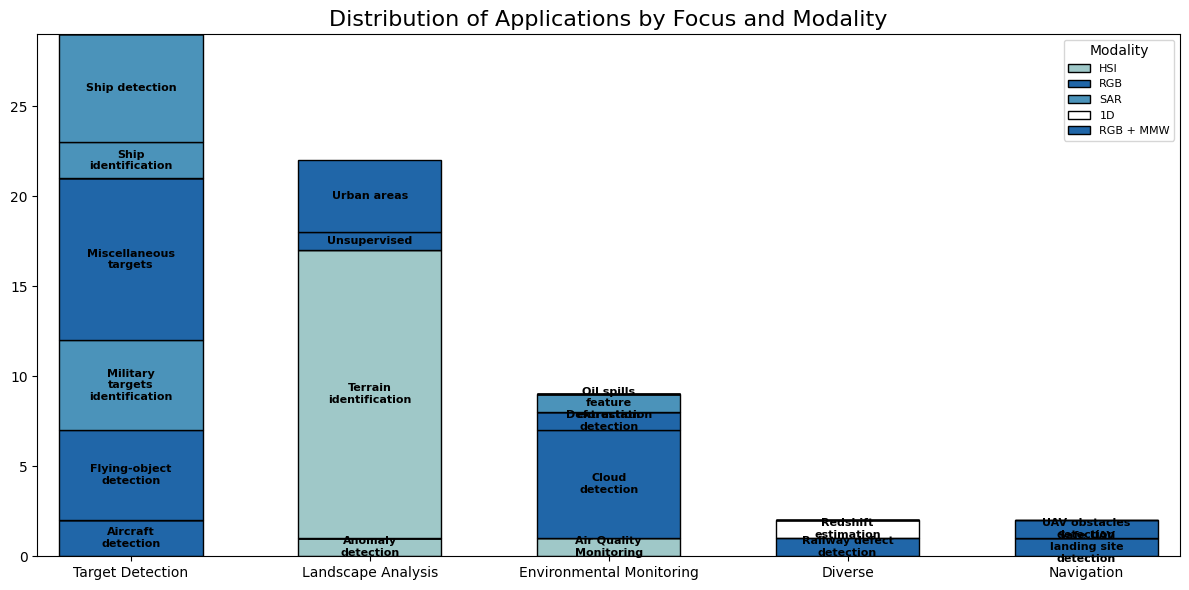

In [39]:
def get_modality_color(modality_str):
    # Custom mapping:
    # - If "RGB" in the string, use blue
    # - "HSI" => purple
    # - "SAR" => gray
    # - "1D" => no fill (white)
    # Default => some fallback color
    if "RGB" in modality_str.upper():
        return "#2066a8"
    elif modality_str.upper() == "HSI":
        return "#9fc8c8"
    elif modality_str.upper() == "SAR":
        return "#4B93BA"
    elif modality_str.upper() == "1D":
        return "none"  # White or transparent
    raise ValueError(f"Unknown modality: {modality_str}")
    # "Classification": "#2066a8",
    # "Pixel classification": "#1f6f6f",
    # "Segmentation": "#9fc8c8",
    # "Object detection": "#af2c2c",
    # "Regression": "#4B93BA",

def plot_stacked_bar_with_modality_colors(data):
    # Prepare DataFrame
    df = data.reset_index(name='Count')
    df['Application Wrapped'] = df['Application'].apply(wrap_label)

    # Pivot with sum to handle duplicates
    pivot_df = df.pivot_table(
        index='Group',
        columns='Application Wrapped',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )

    # Sort tasks by total count descending (biggest on left, smallest on right)
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]

    # Keep track of which modalities have been labeled
    already_labeled = set()

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom_stack = np.zeros(len(pivot_df))

    for app in pivot_df.columns:
        # Find a representative row in df for this app
        # (Pick the first match to get its modality)
        sub_df = df.loc[df['Application Wrapped'] == app]
        if not sub_df.empty:
            modality = sub_df.iloc[0]['Modality']
            bar_color = get_modality_color(modality)
        else:
            # Fallback if not found
            modality = "Unknown"
            bar_color = "lightgray"

        # Show each modality in legend only once
        if modality not in already_labeled:
            label_for_legend = modality
            already_labeled.add(modality)
        else:
            label_for_legend = None

        ax.bar(
            pivot_df.index,
            pivot_df[app],
            bottom=bottom_stack,
            label=label_for_legend,
            color=bar_color,
            edgecolor='black',
            width=0.6
        )

        # Add labels to each sub-bar (in black)
        for i, val in enumerate(pivot_df[app]):
            if val > 0:
                ax.text(
                    i,
                    bottom_stack[i] + val / 2,
                    app,
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='black',
                    fontweight='bold'
                )

        bottom_stack += pivot_df[app]

    # Customization
    ax.set_title("Distribution of Applications by Focus and Modality", fontsize=16)
    ax.set_xticks(range(len(pivot_df.index)))
    ax.set_xticklabels(pivot_df.index, rotation=0, fontsize=10)  # No rotation
    ax.legend(title='Modality', loc='upper right', fontsize=8)
    ax.margins(x=0.02)  # Less space behind bars
    plt.tight_layout()
    plt.show()

# Example usage
data = datapointsDf[["Modality", "Application", "Group"]].value_counts()
plot_stacked_bar_with_modality_colors(data)


### Focus on ML Models Vs. RS Tasks

Try to group the model per "category" this is pretty subjective, but might help visualizing trends.


In [56]:
def add_model_group_column(df):
    """
    Adds a 'Model Group' column to the dataframe based on similarities in model names.

    Args:
        df (DataFrame): The original dataframe containing 'Model', 'Equivalent model', and 'Backbone' columns.

    Returns:
        DataFrame: The dataframe with the new 'Model Group' column added.
    """
    # Define the grouping keywords and their corresponding group labels
    model_group_map = {
        # Deep Learning
        'ALEXNET': 'AlexNet',
        'YOLO': 'YOLO',
        'SSD': 'SSD',
        'VGG': 'VGG',
        'RESNET': 'ResNet',
        'GHOSTNET': 'GhostNet',
        'U-NET': 'CNN',
        'MOBILENET': 'CNN', # to avoid being identify as "LeNet"
        # 'FPN': 'CNN',
        # 'SQUEEZENET': 'CNN',
        # 'ENET': 'CNN',
        # 'ESPNET': 'CNN',
        'LENET': 'LeNet',

        # Shallow Neural Networks
        'MLP': 'Shallow NN',
        'DEEP BELIEF NETWORK': 'Shallow NN',
        'WEIGHTLESS NEURAL SYSTEMS': 'Shallow NN',

        # Graph Neural Networks
        'GNN': 'GNN',

        # Classic Machine Learning
        'SVM': 'Classic ML',
        'DECISION TREE': 'Classic ML',
        'Fuzzy ARTMAP': 'Classic ML',
        'LPDBL': 'Classic ML',
        'ROLLER DUNG BETTLE CLUSTERING': 'Classic ML',
        # Weird and mixed models
        'CAL-SC2S': 'Classic ML',
        'CAG-SC2S': 'Classic ML',

        # Not enough information
        'CNN': 'CNN',
    }

    # Function to assign model group based on keywords in 'Model', 'Equivalent model', and 'Backbone'
    def assign_model_group(row):
        # Combine the values from the three columns
        combined_info = f"{row['Model']} {row['Equivalent model']} {row['Backbone']}".upper()
        for keyword, group_label in model_group_map.items():
            if keyword.upper() in combined_info:
                return group_label
        return 'Other Models'  # Default group if no keywords match

    # Apply the function to the dataframe
    df['Model Group'] = df.apply(assign_model_group, axis=1)
    return df

# Example usage:
# Assuming 'allModelsDF' is your DataFrame
allModelsDF = add_model_group_column(datapointsDf)
print_pretty_df(datapointsDf[["Model", "Equivalent model", "Backbone", "Model Group", "BBT Citation Key"]].sort_values(by="Model Group"))

+----+-------------------------------+------------------+----------------+-------------+-------------------------------------------------------+
|    |             Model             | Equivalent model |    Backbone    | Model Group |                   BBT Citation Key                    |
+----+-------------------------------+------------------+----------------+-------------+-------------------------------------------------------+
| 28 |          AlexNetLite          |     AlexNet      |    AlexNet     |   AlexNet   |         nerisFPGABasedImplementationCNN2022a          |
| 15 |              CNN              |       CNN        |                |     CNN     |          hashimotoShipClassificationSAR2019a          |
| 18 |           HybridSN            |       CNN        |                |     CNN     |                heConfigurable2D3D2023a                |
| 17 |            3D CNN             |       CNN        |                |     CNN     |                heConfigurable2D3D2023a   

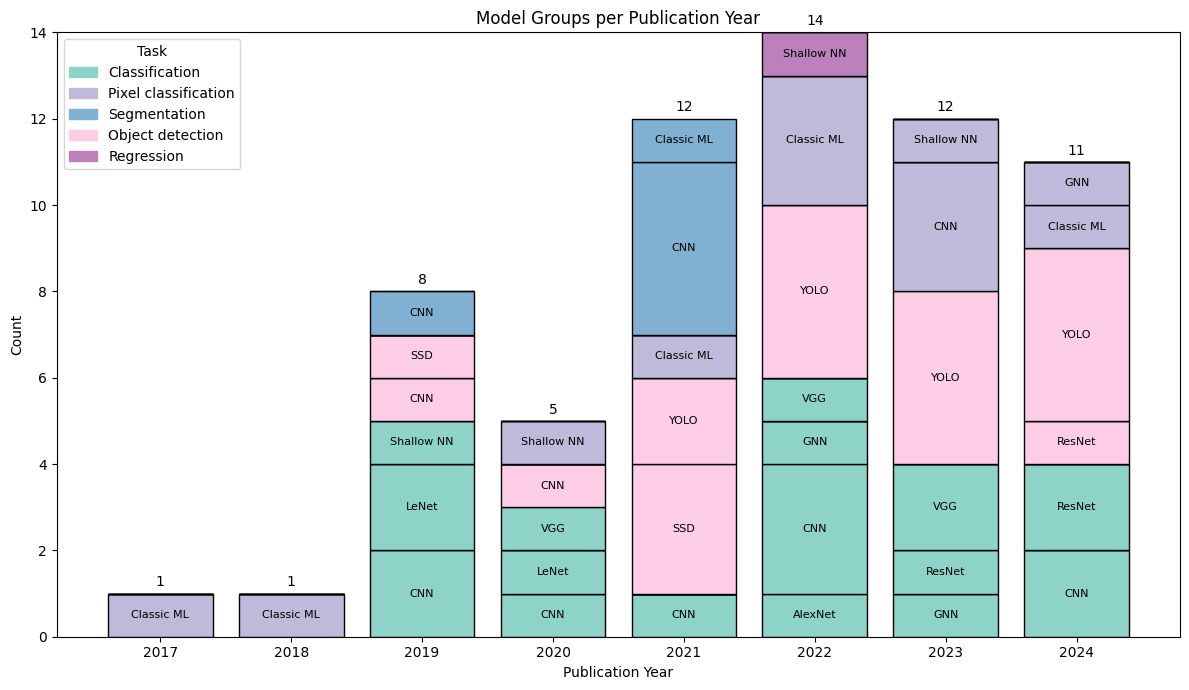

In [57]:
def plot_model_groups_by_year(DataFrame):
    """
    Plot a stacked bar chart showing the number of model groups per publication year.
    Each bar represents a publication year, divided into segments for each Model Group.
    The color of each segment corresponds to the Task.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.patches as mpatches

    # Copy the DataFrame
    DF = DataFrame.copy()
    
    # Force the order of Tasks
    TaskOrder = ['Classification', 'Pixel classification', 'Segmentation', 'Object detection', 'Regression']
    
    # Group data by 'Publication year', 'Task', and 'Model Group', count occurrences
    Counts = DF.groupby(['Publication year', 'Task', 'Model Group']).size().reset_index(name='Count')

    # Remove entries with zero counts
    Counts = Counts[Counts['Count'] > 0]

    # Assign colors to Tasks
    cmap = plt.get_cmap('Set3')
    TaskColors = {task: cmap(i / len(TaskOrder)) for i, task in enumerate(TaskOrder)}
    
    # Pivot data
    PivotDF = Counts.pivot_table(
        index='Publication year',
        columns=['Task', 'Model Group'],
        values='Count',
        fill_value=0
    )

    # Ensure Tasks are in the specified order
    PivotDF = PivotDF.reindex(columns=PivotDF.columns.reindex(TaskOrder, level=0)[0], fill_value=0)
    
    # Sort columns by Task and Model Group
    PivotDF = PivotDF.sort_index(axis=1, level=[0,1], sort_remaining=False)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))

    Bottom = np.zeros(len(PivotDF))
    X = PivotDF.index.astype(str)
    BarWidth = 0.8

    # Calculate total counts per publication year
    TotalCounts = PivotDF.sum(axis=1)

    for (Task, ModelGroup) in PivotDF.columns:
        Counts = PivotDF[(Task, ModelGroup)].values
        if np.all(Counts == 0):
            continue  # Skip if all counts are zero
        Color = TaskColors.get(Task, '#333333')
        Bars = ax.bar(
            X,
            Counts,
            bottom=Bottom,
            color=Color,
            edgecolor='black',
            width=BarWidth
        )
        # Add model group name as label within sub-bar if count > 0
        Labels = [ModelGroup if count > 0 else '' for count in Counts]
        ax.bar_label(Bars, labels=Labels, label_type='center', fontsize=8)
        Bottom += Counts

    # Add total count labels on top of each yearly bar
    for i, total in enumerate(TotalCounts):
        ax.text(i, TotalCounts.iloc[i] + 0.1, f"{int(TotalCounts.iloc[i])}", ha='center', va='bottom')

    # Create legend for Tasks
    Handles = [mpatches.Patch(color=TaskColors[task], label=task) for task in TaskOrder]
    ax.legend(handles=Handles, title='Task', loc='upper left')

    ax.set_title('Model Groups per Publication Year')
    ax.set_xlabel('Publication Year')
    ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Example usage
plot_model_groups_by_year(datapointsDf[['Model Group', 'Publication year', 'Task']])

### Focus on Datasets, Tasks and Modalities


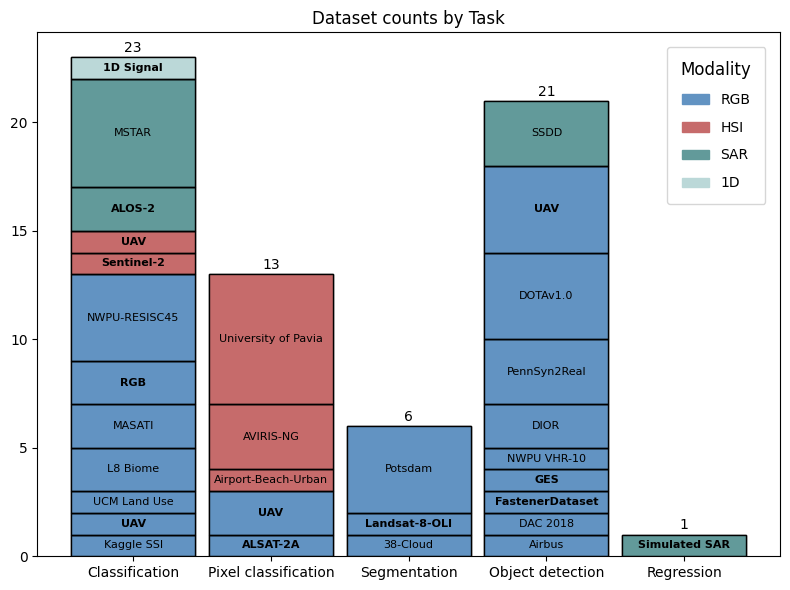

In [60]:
def plot_datasets_v2_stacked_bar_chart(dataframe):
    """_summary_
    Function to plot a stacked bar chart of datasets grouped by Task.
    Each bar represents a Task, divided into segments for each Dataset.
    Datasets within each bar are grouped by Modality and sorted by counts.
    Sub-bars are colored based on Modality.

    Args:
        dataframe (Dataframe): A DataFrame containing the columns 'Task', 'Dataset', and 'Modality'
    """
    dataframe = dataframe.copy() # avoid SettingWithCopyWarning

    # Clean some data
    dataframe['Modality'] = dataframe['Modality'].str.split('+').str[0].str.strip()
    dataframe['Dataset'] = dataframe['Dataset'].replace({
        "UAV RGB+MMW (cust.) {Object Detection}": "UAV (cust.) {Object Detection}",
        "UAV RGB (cust.) {Object Detection}": "UAV (cust.) {Object Detection}",
        "UAV RGB (cust.) {Classification}": "UAV (cust.) {Classification}",
        "UAV RGB (cust.) {Pixel classification}": "UAV (cust.) {Pixel classification}",
        "UC-Merced Land Use {Classification}": "UCM Land Use {Classification}",
        "Google Earth Studio RGB (sim.) {Object Detection}": "GES (sim.) {Object Detection}",
        "SAR (sim.) {Regression}": "Simulated SAR (sim.) {Regression}",
    })

    # Identify customized or simulated datasets
    customOrSimulatedDatasets = []
    for dataset in dataframe['Dataset'].unique():
        datasetName = dataset.split(' {')[0].strip()
        if "(cust" in dataset or "(sim" in dataset:
            customOrSimulatedDatasets.append(dataset.split(' (')[0].strip())

    datasetCounts = dataframe.groupby(['Task', 'Dataset', 'Modality']).size().reset_index(name='Count')
    
    taskOrder = ['Classification', 'Pixel classification', 'Segmentation', 'Object detection', 'Regression']
    
    modalityOrder = ['RGB', 'HSI', 'SAR']
    otherModalities = [mod for mod in dataframe['Modality'].unique() if mod not in modalityOrder]
    modalityOrder.extend(otherModalities)
    
    modalityColors = {
        'RGB': '#6293c2',
        'HSI': '#c66b6b', 
        'SAR': '#629a9a',
        '1D': '#bbd8d8',
    }

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    barWidth = 0.9  # Make the bars wider
    xPositions = np.arange(len(taskOrder))

    TotalCounts = datasetCounts.groupby('Task')['Count'].sum().reindex(taskOrder).tolist()

    for index, task in enumerate(taskOrder):
        # Get datasets and counts for this task
        taskData = datasetCounts[datasetCounts['Task'] == task].copy()

        # Sort datasets by Modality and counts in ascending order
        taskData['ModalityOrder'] = taskData['Modality'].apply(
            lambda m: modalityOrder.index(m) if m in modalityOrder else len(modalityOrder)
        )
        taskData = taskData.sort_values(['ModalityOrder', 'Count'], ascending=[True, True]).reset_index(drop=True)
        taskData = taskData.drop(columns='ModalityOrder')

        total = taskData['Count'].sum()
        # Draw the outline of the bar
        ax.bar(xPositions[index], total, width=barWidth, edgecolor='black', linewidth=1, color='white')

        # Compute cumulative counts for plotting
        counts = taskData['Count']
        cumCounts = counts.cumsum()
        cumCounts = [0] + cumCounts.tolist()

        xLeft = xPositions[index] - barWidth / 2
        xRight = xPositions[index] + barWidth / 2

        # Add colored segments and labels within the bar
        for i, row in taskData.iterrows():
            count = row['Count']
            modality = row['Modality']
            dataset = row['Dataset']
            color = modalityColors.get(modality, '#A9A9A9')
            yBottom = cumCounts[i]
            yTop = cumCounts[i + 1]

            # Draw the colored segment
            ax.bar(
                xPositions[index],
                count,
                bottom=yBottom,
                width=barWidth,
                color=color,
                edgecolor='black',
                linewidth=1
            )

            # Add label within the segment
            datasetLabel = dataset.split(' {')[0].split(' (')[0]
            yPosition = yBottom + count / 2
            if datasetLabel in customOrSimulatedDatasets:
                fontWeight = 'bold'
            else:
                fontWeight = 'normal'
            ax.text(
                xPositions[index],
                yPosition,
                datasetLabel,
                ha='center',
                va='center',
                fontsize=8,
                weight=fontWeight
            )

        # Add horizontal lines between datasets
        for y in cumCounts[1:-1]:  # Exclude first (0) and last (total)
            ax.hlines(y, xLeft, xRight, colors='black', linewidth=1)
    
    # Add total count labels on top of each yearly bar
    for i, total in enumerate(TotalCounts):
        ax.text(i, TotalCounts[i] + 0.1, f"{int(TotalCounts[i])}", ha='center', va='bottom')
    
    # Create legend for modalities in the specified order
    handles = [
        mpatches.Patch(color=modalityColors[modality], label=modality)
        for modality in modalityOrder if modality in modalityColors
    ]
    ax.legend(
        handles=handles,
        title='Modality',
        loc='upper right',
        title_fontsize=12,     # Increase the title font size
        fontsize=10,           # Increase the label font size
        borderpad=1,           # Increase the padding between the border and the content
        labelspacing=1,        # Increase the vertical space between labels
        handlelength=2,        # Increase the length of the legend handles
        handletextpad=0.8,     # Increase space between handle and text
        borderaxespad=1.05      # Increase the space between the legend and the axes
    )

    ax.set_yticks(range(0, 21, 5))
    ax.set_xticks(xPositions)
    ax.set_xticklabels(taskOrder)
    ax.set_title('Dataset counts by Task')

    plt.tight_layout()
    plt.show()

plot_datasets_v2_stacked_bar_chart(datapointsDf[['Task', 'Dataset', 'Modality']])